# BOSTON PET STORE BUSINESS 

**Introduction**

In this time people are worried about pets, from spiders to horses, and now that people spend more time in social media, many of them decide to have a pet friend. The problem in many cities is access to the pet store, sometimes are far away from home. In this case, I'm not only want to analyze where the pet store is, but I also want to add two components, a coffee shop and a pizza place. Why? Because I think that the most popular venues can help to  develop a new business helping with a big flux of people 

## Table of contents

1. Data, finding and exploring
2. Exploring Neighborhoods in Boston city 
3. Clustering Neighborhoods
4. Analyzing clusters
5. Finding exploring data related to pets in Boston city

Download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


**1. Download and explore data set**

Boston city has 23 neighborhoods. We can extract information through www.data.boston.gov where we can find json, csv and meny others files.

Load and explore the data set.

In [4]:
df = pd.read_csv('Boston_data_csv.csv')

print('Data downloaded and read into a dataframe!')
#df.head() check the dataframe

Data downloaded and read into a dataframe!


Save the file as csv.

In [5]:
df.to_csv('dfcsv.csv', sep=',')
df.head()

,name,neighborhood_ID,latitude,longitude
0,Roslindale,15,42.282515,-71.126662
1,Jamaica Plain,11,42.307761,-71.115096
2,Mission Hill,13,42.331733,-71.102606
3,Longwood,28,42.338600,-71.105102
4,Bay Village,33,42.349095,-71.069031


We can get the latitude and longitude values of Boston City using geopy library .

In [6]:
address = 'Boston, MS'

geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston City are 42.3306533, -71.0914404.


Create a map of Boston with neighborhoods superimposed on top

In [7]:
map_boston = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name in zip(df['latitude'], df['longitude'],  df['name']):
    label = '{}'.format(df)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
map_boston.save('Boston.html')    
map_boston

Now we add Foursquare Credentials and Version

In [8]:
CLIENT_ID = 'ZFGJMBLROE02FJR2DHPIYB2KE5514IO2VLKCOGSVMPCYFMBD' # your Foursquare ID
CLIENT_SECRET = '0QIALZFLYEQY4DOQA2I3MYNGH4YMFXOI3ERHDZU5DFT2TSDR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZFGJMBLROE02FJR2DHPIYB2KE5514IO2VLKCOGSVMPCYFMBD
CLIENT_SECRET:0QIALZFLYEQY4DOQA2I3MYNGH4YMFXOI3ERHDZU5DFT2TSDR


The first neighborhood in our dataframe will be:

In [9]:
df.loc[0, 'name']

'Roslindale'

We can get the neighborhood's latitude and longitude values as follow:

In [10]:
#Get the neighborhood's latitude and longitude values.
neighborhood_latitude = df.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'longitude'] # neighborhood longitude value

neighborhood_name = df.loc[0, 'name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Roslindale are 42.2825152806, -71.126661984.


Now, let's get the top 100 venues that are in Roslindale within a radius of 900 meters. First We need the GET request URL. Name your URL url.

In [11]:
LIMIT = 200 # limit of number of venues returned by Foursquare API

radius = 900 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=ZFGJMBLROE02FJR2DHPIYB2KE5514IO2VLKCOGSVMPCYFMBD&client_secret=0QIALZFLYEQY4DOQA2I3MYNGH4YMFXOI3ERHDZU5DFT2TSDR&v=20180605&ll=42.2825152806,-71.126661984&radius=900&limit=200'

Send the GET request and examine the resutls. 

In [13]:
results = requests.get(url).json()
#results

I borrow the get_category_type function from the Foursquare lab.

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we clean the json and structure it into a pandas dataframe.

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.to_csv('nearby_venues.csv',sep=',')
nearby_venues.head()

,name,categories,lat,lng
0,Fornax Bread Company,Bakery,42.286171,-71.129760
1,Roslindale Square,Plaza,42.285815,-71.129304
2,Roslindale Village Farmers Market,Farmers Market,42.286534,-71.128509
3,Delfino’s,Italian Restaurant,42.287106,-71.129470
4,Sophia's Grotto,Italian Restaurant,42.286616,-71.129869


Let's check how many venues were returned by Foursquare.

In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

40 venues were returned by Foursquare.


**2. Explore Neighborhoods in Boston city**

Let's create a function to repeat the same process to all the neighborhoods in Boston

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=900):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called boston_venues

In [18]:
boston_venues = getNearbyVenues(names=df['name'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

Roslindale
Jamaica Plain
Mission Hill
Longwood
Bay Village
Leather District
Chinatown
North End
Roxbury
South End
Back Bay
East Boston
Charlestown
West End
Beacon Hill
Downtown
Fenway
Brighton
West Roxbury
Mattapan
Dorchester
South Boston Waterfront
South Boston
Allston
Harbor Islands


Let's take a look

In [19]:
print(boston_venues.shape)
boston_venues.to_csv('boston_venues.csv',sep=',')
boston_venues.head()

(1834, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Roslindale,42.282515,-71.126662,Fornax Bread Company,42.286171,-71.129760,Bakery
1,Roslindale,42.282515,-71.126662,Roslindale Square,42.285815,-71.129304,Plaza
2,Roslindale,42.282515,-71.126662,Roslindale Village Farmers Market,42.286534,-71.128509,Farmers Market
3,Roslindale,42.282515,-71.126662,Delfino’s,42.287106,-71.129470,Italian Restaurant
4,Roslindale,42.282515,-71.126662,Sophia's Grotto,42.286616,-71.129869,Italian Restaurant


Let's check how many venues were returned for each neighborhood

In [20]:
boston_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allston,100,100,100,100,100,100
Back Bay,100,100,100,100,100,100
Bay Village,100,100,100,100,100,100
Beacon Hill,100,100,100,100,100,100
Brighton,55,55,55,55,55,55
Charlestown,52,52,52,52,52,52
Chinatown,100,100,100,100,100,100
Dorchester,36,36,36,36,36,36
Downtown,100,100,100,100,100,100


Let's find out how many unique categories can be curated from all the returned venues

In [21]:
print('There are {} uniques categories.'.format(len(boston_venues['Venue Category'].unique())))

There are 243 uniques categories.


Analyze each neighborhood

In [23]:
# one hot encoding
boston_onehot = pd.get_dummies(boston_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
boston_onehot['Neighborhood'] = boston_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]

boston_onehot.head()

,Yoga Studio,ATM,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Cambodian Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Bookstore,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Plane,Planetarium,Playground,Plaza,Pool,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Resort,Restaurant,River,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Ski Chalet,Smoke Shop,Soccer Field,Social Club,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tour Provider,Tourist Information Center,Track,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waste Facility,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Roslindale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.


In [24]:
boston_onehot.shape

(1834, 243)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
boston_grouped = boston_onehot.groupby('Neighborhood').mean().reset_index()
boston_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Cambodian Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Bookstore,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Other Great Outdoors,Other Repair Shop,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Plane,Planetarium,Playground,Plaza,Pool,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Resort,Restaurant,River,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Ski Chalet,Smoke Shop,Soccer Field,Social Club,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Tour Provider,Tourist Information Center,Track,Trail,Train,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Waste Facility,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Allston,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.020000,0.020000,0.00,0.000000,0.000000,0.040000,0.000000,0.020000,0.010000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.01,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.010000,0.02,0.010000,0.000000,0.000000,0.000000,0.010000,0.00,0.000000,0.00,0.000,0.040000,0.00,0.00,0.00,0.00,0.00,0.00,0.040000,0.00,0.00,0.01,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.01,0.000000,0.000000,0.020000,0.000000,0.01,0.000000,0.010000,0.010000,0.000,0.000000,0.00,0.00

Let's confirm the new size

In [26]:
boston_grouped.shape

(25, 243)

Let's print each neighborhood along with the top 10 most common venues

In [27]:
num_top_venues = 10

for hood in boston_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = boston_grouped[boston_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allston----
                  venue  freq
0     Korean Restaurant  0.06
1                Bakery  0.04
2       Thai Restaurant  0.04
3           Coffee Shop  0.04
4    Chinese Restaurant  0.04
5      Sushi Restaurant  0.03
6           Pizza Place  0.03
7   Rental Car Location  0.03
8    Seafood Restaurant  0.02
9  Gym / Fitness Center  0.02


----Back Bay----
                 venue  freq
0          Coffee Shop  0.06
1  American Restaurant  0.05
2                Hotel  0.04
3   Italian Restaurant  0.04
4   Seafood Restaurant  0.04
5       Cosmetics Shop  0.03
6   Salon / Barbershop  0.03
7       Ice Cream Shop  0.03
8          Men's Store  0.02
9       Chocolate Shop  0.02


----Bay Village----
                 venue  freq
0              Theater  0.06
1                  Spa  0.06
2   Italian Restaurant  0.05
3  American Restaurant  0.05
4                  Gym  0.04
5           Steakhouse  0.03
6                Hotel  0.03
7          Coffee Shop  0.03
8   Seafood Restaurant  0.03
9   

Let's put that into a pandas dataframe writing a function to sort the venues in descending order.


In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = boston_grouped['Neighborhood']

for ind in np.arange(boston_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(boston_grouped.iloc[ind, :], num_top_venues)
#neighborhoods_venues_sorted.to_csv('neighborhood_venues_sorted.csv',sep=',')
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allston,Korean Restaurant,Thai Restaurant,Chinese Restaurant,Bakery,Coffee Shop,Sushi Restaurant,Pizza Place,Rental Car Location,Asian Restaurant,Seafood Restaurant
1,Back Bay,Coffee Shop,American Restaurant,Hotel,Italian Restaurant,Seafood Restaurant,Cosmetics Shop,Salon / Barbershop,Ice Cream Shop,Juice Bar,French Restaurant
2,Bay Village,Spa,Theater,American Restaurant,Italian Restaurant,Gym,Steakhouse,Coffee Shop,Hotel,Seafood Restaurant,Performing Arts Venue
3,Beacon Hill,Italian Restaurant,Hotel,Pizza Place,Sandwich Place,Coffee Shop,Gourmet Shop,Spa,French Restaurant,Park,Theater
4,Brighton,Pizza Place,Pub,Chinese Restaurant,Bakery,Café,Sushi Restaurant,Coffee Shop,Grocery Store,Greek Restaurant,Convenience Store


**3.Clustering Neighborhoods**

Run k-means to cluster the neighborhood into 5 clusters.

In [30]:
# set number of clusters
kclusters = 5

boston_grouped_clustering = boston_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 3, 3, 0, 0, 3, 0, 3, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster-labels', kmeans.labels_)

boston_merged = df

# merge boston_grouped with boston data to add latitude/longitude for each neighborhood
boston_merged = boston_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='name')

boston_merged.tail() # check the last columns!

,name,neighborhood_ID,latitude,longitude,Cluster-labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Dorchester,6,42.298454,-71.063456,0,Vietnamese Restaurant,Café,Park,Sandwich Place,Food,Fast Food Restaurant,Southern / Soul Food Restaurant,Liquor Store,Market,Seafood Restaurant
21,South Boston Waterfront,29,42.346408,-71.041726,3,Seafood Restaurant,Coffee Shop,Italian Restaurant,Hotel,Restaurant,Asian Restaurant,Gym,Steakhouse,Mediterranean Restaurant,Sandwich Place
22,South Boston,17,42.334900,-71.044643,0,Pizza Place,Coffee Shop,Bar,Italian Restaurant,Convenience Store,Chinese Restaurant,New American Restaurant,Gym,Liquor Store,Diner
23,Allston,24,42.358397,-71.128562,0,Korean Restaurant,Thai Restaurant,Chinese Restaurant,Bakery,Coffee Shop,Sushi Restaurant,Pizza Place,Rental Car Location,Asian Restaurant,Seafood Restaurant
24,Harbor Islands,22,42.327932,-70.968775,1,Other Great Outdoors,Women's Store,Dive Bar,Flower Shop,Fish Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Duty-free Shop


Now we can put these information into a map

In [32]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(boston_merged['latitude'], boston_merged['longitude'], boston_merged['name'], boston_merged['Cluster-labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
#map_clusters.save('Boston_clusters.html')       
map_clusters

**4. Analyzing clusters**

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. 

Cluster 1

In [33]:
#cluster 1
boston_merged.loc[boston_merged['Cluster-labels'] == 0, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,neighborhood_ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,15,Yoga Studio,American Restaurant,Italian Restaurant,Liquor Store,Plaza,Chinese Restaurant,Sandwich Place,Bar,Pizza Place,Gastropub
1,11,Park,Pizza Place,Bakery,Yoga Studio,Pub,Coffee Shop,New American Restaurant,Art Gallery,Accessories Store,Ice Cream Shop
2,13,Pizza Place,Donut Shop,Sandwich Place,Café,Sushi Restaurant,Gym,Italian Restaurant,Falafel Restaurant,Art Gallery,Bus Station
12,4,Pizza Place,National Park,Coffee Shop,Grocery Store,Gastropub,Pub,Gym,Convenience Store,Seafood Restaurant,Bus Station
17,25,Pizza Place,Pub,Chinese Restaurant,Bakery,Café,Sushi Restaurant,Coffee Shop,Grocery Store,Greek Restaurant,Convenience Store
18,19,Convenience Store,Pizza Place,American Restaurant,Liquor Store,Discount Store,Italian Restaurant,Pharmacy,Grocery Store,Salon / Barbershop,Gym
19,12,Home Service,Pharmacy,Liquor Store,Bakery,BBQ Joint,Park,Pizza Place,Cosmetics Shop,Rental Car Location,Caribbean Restaurant
20,6,Vietnamese Restaurant,Café,Park,Sandwich Place,Food,Fast Food Restaurant,Southern / Soul Food Restaurant,Liquor Store,Market,Seafood Restaurant
22,17,Pizza Place,Coffee Shop,Bar,Italian Restaurant,Convenience Store,Chinese Restaurant,New American Restaurant,Gym,Liquor Store,Diner
23,24,Korean Restaurant,Thai Restaurant,Chinese Restaurant,Bakery,Coffee Shop,Sushi Restaurant,Pizza Place,Rental Car Location,Asian Restaurant,Seafood Restaurant


Cluster 2

In [34]:
#cluster1
boston_merged.loc[boston_merged['Cluster-labels'] == 1, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,neighborhood_ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,22,Other Great Outdoors,Women's Store,Dive Bar,Flower Shop,Fish Market,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Electronics Store,Duty-free Shop


Cluster 3

In [35]:
#cluster1
boston_merged.loc[boston_merged['Cluster-labels'] == 2, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,neighborhood_ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,14,Italian Restaurant,Bakery,Park,Pizza Place,Seafood Restaurant,Market,Coffee Shop,Café,Sandwich Place,Historic Site


Cluster 4

In [36]:
#cluster1
boston_merged.loc[boston_merged['Cluster-labels'] == 3, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,neighborhood_ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,28,Café,Donut Shop,American Restaurant,Coffee Shop,Art Museum,Sandwich Place,Bakery,Greek Restaurant,Hotel,Pizza Place
4,33,Spa,Theater,American Restaurant,Italian Restaurant,Gym,Steakhouse,Coffee Shop,Hotel,Seafood Restaurant,Performing Arts Venue
5,27,Asian Restaurant,Coffee Shop,Chinese Restaurant,Bakery,Performing Arts Venue,Sandwich Place,Italian Restaurant,Sushi Restaurant,Theater,Spa
6,26,Chinese Restaurant,Asian Restaurant,Bakery,Coffee Shop,Italian Restaurant,Sushi Restaurant,Theater,Vegetarian / Vegan Restaurant,Pizza Place,Sandwich Place
9,32,Italian Restaurant,Wine Bar,Coffee Shop,Bakery,American Restaurant,French Restaurant,Park,Pet Store,Café,Mexican Restaurant
10,2,Coffee Shop,American Restaurant,Hotel,Italian Restaurant,Seafood Restaurant,Cosmetics Shop,Salon / Barbershop,Ice Cream Shop,Juice Bar,French Restaurant
11,8,Donut Shop,Coffee Shop,American Restaurant,Pizza Place,Airport Lounge,Brewery,Café,Airport,Airport Service,Border Crossing
13,31,Coffee Shop,Hotel,Italian Restaurant,Park,Pizza Place,Bakery,Seafood Restaurant,Science Museum,Salon / Barbershop,Mexican Restaurant
14,30,Italian Restaurant,Hotel,Pizza Place,Sandwich Place,Coffee Shop,Gourmet Shop,Spa,French Restaurant,Park,Theater
15,7,Coffee Shop,Historic Site,Italian Restaurant,Salad Place,Park,New American Restaurant,Sandwich Place,Seafood Restaurant,Hotel,American Restaurant


Cluster 5

In [37]:
#cluster1
boston_merged.loc[boston_merged['Cluster-labels'] == 4, boston_merged.columns[[1] + list(range(5, boston_merged.shape[1]))]]

,neighborhood_ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,16,Park,Pharmacy,Gym / Fitness Center,Liquor Store,Caribbean Restaurant,Fried Chicken Joint,Department Store,Grocery Store,Gas Station,American Restaurant


**5. Exploring data related to pets in Boston city.**

Now let's find a specific venue category

In [43]:
address = '274 Southampton, Boston, MA'

geolocator = Nominatim(user_agent="4sq_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

42.3308529285714 -71.0642894285714


In [44]:
search_query = 'Pet'
radius = 1000
print(search_query + ' .... OK!')

Pet .... OK!


In [45]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=ZFGJMBLROE02FJR2DHPIYB2KE5514IO2VLKCOGSVMPCYFMBD&client_secret=0QIALZFLYEQY4DOQA2I3MYNGH4YMFXOI3ERHDZU5DFT2TSDR&ll=42.3308529285714,-71.0642894285714&v=20180605&query=Pet&radius=1000&limit=200'

In [46]:
results2 = requests.get(url).json()
results2

{'meta': {'code': 200, 'requestId': '5ce30f836a6071493fe63060'},
 'response': {'venues': [{'id': '4d2c8ee1888af04d2476e9af',
    'name': 'Red Dog Pet Resort & Spa',
    'location': {'address': '274 Southampton St',
     'lat': 42.33124340029047,
     'lng': -71.06395657609552,
     'labeledLatLngs': [{'label': 'display',
       'lat': 42.33124340029047,
       'lng': -71.06395657609552}],
     'distance': 51,
     'postalCode': '02118',
     'cc': 'US',
     'city': 'Boston',
     'state': 'MA',
     'country': 'United States',
     'formattedAddress': ['274 Southampton St',
      'Boston, MA 02118',
      'United States']},
    'categories': [{'id': '5032897c91d4c4b30a586d69',
      'name': 'Pet Service',
      'pluralName': 'Pet Services',
      'shortName': 'Pet Service',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/pet_store_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '94000467'},
    'referralId': 'v-1558384515',
    'has

Now we can extract the information

In [47]:
# assign relevant part of JSON to venues
venues = results2['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId,venuePage.id
0,"[{'id': '5032897c91d4c4b30a586d69', 'name': 'P...",False,4d2c8ee1888af04d2476e9af,274 Southampton St,US,Boston,United States,51,"[274 Southampton St, Boston, MA 02118, United ...","[{'label': 'display', 'lat': 42.33124340029047...",42.331243,-71.063957,02118,MA,Red Dog Pet Resort & Spa,v-1558384515,94000467
1,"[{'id': '4bf58dd8d48988d100951735', 'name': 'P...",False,4bbf859fabf49521f1c8bd93,274 Southampton St,US,Boston,United States,591,"[274 Southampton St, Boston, MA 02118, United ...","[{'label': 'display', 'lat': 42.33245215, 'lng...",42.332452,-71.071146,02118,MA,Skipton Pet Center,v-1558384515,NaN
2,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",False,4c4f4658bec4d13a0f9bf961,371 Dorchester Ave,US,Boston,United States,709,"[371 Dorchester Ave, Boston, MA 02127, United ...","[{'label': 'display', 'lat': 42.3351742213561,...",42.335174,-71.057952,02127,MA,Peter Welch's Gym,v-1558384515,42707781
3,"[{'id': '4bf58dd8d48988d177941735', 'name': 'D...",False,5bdb49f1b3c961002cf36332,725 Albany St Fl 3,US,Boston,United States,774,"[725 Albany St Fl 3, Boston, MA 02118, United ...","[{'label': 'display', 'lat': 42.33471286530766...",42.334713,-71.072117,02118,MA,"Peter A Burke, MD",v-1558384515,NaN
4,"[{'id': '4bf58dd8d48988d177941735', 'name': 'D...",False,5bdb4e5b97cf5a002c8bad2f,1 Boston Medical Ctr Pl,US,Boston,United States,890,"[1 Boston Medical Ctr Pl, Boston, MA 02118, Un...","[{'label': 'display', 'lat': 42.3344435, 'lng'...",42.334443,-71.073960,02118,MA,"Peter Rempelakis, LICSW",v-1558384515,NaN


Cleaning the data frame

In [48]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,cc,city,country,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,Red Dog Pet Resort & Spa,Pet Service,274 Southampton St,US,Boston,United States,51,"[274 Southampton St, Boston, MA 02118, United ...","[{'label': 'display', 'lat': 42.33124340029047...",42.331243,-71.063957,02118,MA,4d2c8ee1888af04d2476e9af
1,Skipton Pet Center,Pet Store,274 Southampton St,US,Boston,United States,591,"[274 Southampton St, Boston, MA 02118, United ...","[{'label': 'display', 'lat': 42.33245215, 'lng...",42.332452,-71.071146,02118,MA,4bbf859fabf49521f1c8bd93
2,Peter Welch's Gym,Gym,371 Dorchester Ave,US,Boston,United States,709,"[371 Dorchester Ave, Boston, MA 02127, United ...","[{'label': 'display', 'lat': 42.3351742213561,...",42.335174,-71.057952,02127,MA,4c4f4658bec4d13a0f9bf961
3,"Peter A Burke, MD",Doctor's Office,725 Albany St Fl 3,US,Boston,United States,774,"[725 Albany St Fl 3, Boston, MA 02118, United ...","[{'label': 'display', 'lat': 42.33471286530766...",42.334713,-71.072117,02118,MA,5bdb49f1b3c961002cf36332
4,"Peter Rempelakis, LICSW",Doctor's Office,1 Boston Medical Ctr Pl,US,Boston,United States,890,"[1 Boston Medical Ctr Pl, Boston, MA 02118, Un...","[{'label': 'display', 'lat': 42.3344435, 'lng'...",42.334443,-71.073960,02118,MA,5bdb4e5b97cf5a002c8bad2f
5,Bon Me - Peters Park,Food Truck,NaN,US,Boston,United States,1179,"[Boston, MA, United States]","[{'label': 'display', 'lat': 42.34128783674556...",42.341288,-71.066790,NaN,MA,51c6073f498e8dcda328d8cf


Let's visualize the Pet stores that are nearby

In [49]:
dataframe_filtered.name

0    Red Dog Pet Resort & Spa
1          Skipton Pet Center
2           Peter Welch's Gym
3           Peter A Burke, MD
4     Peter Rempelakis, LICSW
5        Bon Me - Peters Park
Name: name, dtype: object

In [50]:
venues_map1 = folium.Map(location=[latitude, longitude], zoom_start=14) # generate map centred around the 274 Southampton

# add a red circle marker to represent the Pet Store
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Pet Store',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map1)

# add the pet stores as blue circle markers
for lat, lng in zip(dataframe_filtered.lat, dataframe_filtered.lng):
#for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map1)

#venues_map1.save('venues_map1.html')   
# display map
venues_map1

Important: this map could change if we running many times.

**Pet statistics**

Now we have an idea of the top business by neighborhood in Boston city. In this point, we can return to the idea presented in the introduction. Now we know the possibles neighborhoods where start a pet store without interfering with the other pet stores and using the popularity of the venue to attract the customers. According to Pets Statistics ([1]-> https://www.iii.org/fact-statistic/facts-statistics-pet-statistics#NUMBER%20OF%20U.S.%20HOUSEHOLDS%20THAT%20OWN%20A%20PET,%20BY%20TYPE%20OF%20ANIMAL), sixty-eight percent own a pet (around 85 million) between 2017 and 2018. 

The number of U.S households that own a pet by type of animal [1] (millions)

In [52]:
pet1 = pd.read_csv('number_of_households_that_own_a_pet.csv')
pet1

,Pet,Number
0,Dog,60.2
1,Cat,47.1
2,Freshwater fish,12.5
3,Bird,7.9
4,Small animal,6.7
5,Reptile,4.7
6,Horse,2.6
7,Saltwater fish,2.5


Total number of pets owned in the U.S by type of animal [1] (millions)

In [54]:
pet2 = pd.read_csv('total_number_of_pets_owned_us.csv')
pet2

,Pet,Number
0,Freshwater fish,139.3
1,Cat,94.2
2,Dog,89.7
3,Bird,20.3
4,Saltwater fish,18.8
5,Small animal,14.0
6,Reptile,9.4
7,Horse,7.6


Total of U.S pet industry expenditures, 2007-2017 [1] ($ billions) 

In [55]:
pet3 = pd.read_csv('total_pets_industry_expenditure_us.csv')
pet3

,Year,Expenditure
0,2007,41.2
1,2008,43.2
2,2009,45.5
3,2010,48.4
4,2011,51.0
5,2012,53.3
6,2013,55.7
7,2014,58.0
8,2015,60.3
9,2016,66.8


Let's visualyze the data

In [57]:
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline

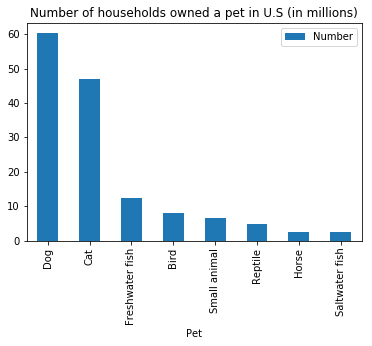

In [58]:
p1=pet1.plot(x ='Pet', y='Number', title='Number of households owned a pet in U.S (in millions)' ,kind = 'bar')
#plt.savefig('p1')

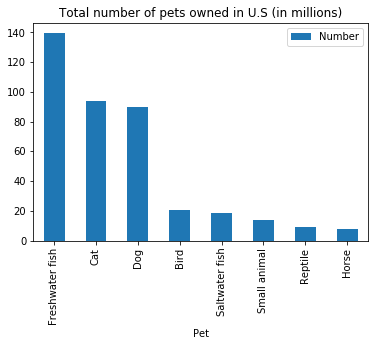

In [59]:
p2=pet2.plot(x ='Pet', y='Number', title='Total number of pets owned in U.S (in millions)' ,kind = 'bar')	
#plt.savefig('p2')

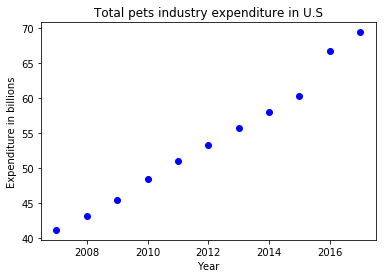

In [60]:
plt.scatter(pet3.Year, pet3.Expenditure,  color='blue')
plt.title('Total pets industry expenditure in U.S')
plt.xlabel("Year")
plt.ylabel("Expenditure in billions")
#plt.savefig('p3')
plt.show()

First we need to create a mask

In [61]:
msk = np.random.rand(len(pet3)) < 0.7
train = pet3[msk]
test = pet3[~msk]

We will separate our trainning sets

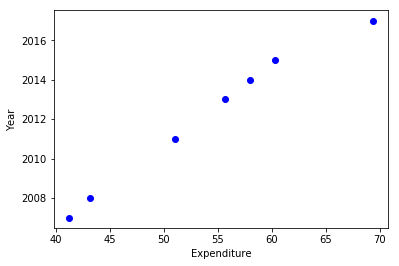

In [62]:
plt.scatter(train.Expenditure, train.Year,  color='blue')
plt.xlabel("Expenditure")
plt.ylabel("Year")
plt.show()

Now we introduce the linear regression model and we start to trainning

In [63]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
train_x = np.asanyarray(train[['Expenditure']])
train_y = np.asanyarray(train[['Year']])
regr.fit (train_x, train_y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print ('Intercept: ',regr.intercept_)

Coefficients:  [[0.36861251]]
Intercept:  [1992.19565419]


Let's check the results

Text(0, 0.5, 'Year')

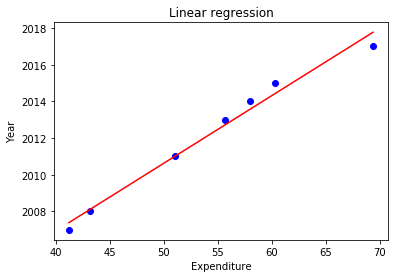

In [64]:
plt.scatter(train.Expenditure, train.Year,  color='blue')
plt.plot(train_x, regr.coef_[0][0]*train_x + regr.intercept_[0], '-r')
plt.title('Linear regression')
plt.xlabel("Expenditure")
plt.ylabel("Year")
#plt.savefig('lr')

And finally let's take a look if our model has good R2-Score

In [65]:
from sklearn.metrics import r2_score

test_x = np.asanyarray(test[['Expenditure']])
test_y = np.asanyarray(test[['Year']])
test_y_hat = regr.predict(test_x)

print("Mean absolute error: %.2f" % np.mean(np.absolute(test_y_hat - test_y)))
print("Residual sum of squares (MSE): %.2f" % np.mean((test_y_hat - test_y) ** 2))
print("R2-score: %.2f" % r2_score(test_y_hat , test_y) )

Mean absolute error: 0.26
Residual sum of squares (MSE): 0.17
R2-score: 0.98
